In [100]:
from google.cloud import bigquery
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from datetime import timedelta
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import RFECV
import xgboost as xgb
from xgboost_distribution import XGBDistribution
from sklearn.metrics import mean_squared_error

warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", None)
pd.set_option('display.width', 10000)

# Change the project name here to your project name in your account
# client = bigquery.Client(project="ambient-sylph-426620-g6") # Odele

client = bigquery.Client(project="plucky-snowfall-438110-f2")

In [102]:
query = '''
    WITH purchases as(
        SELECT distinct
            fullVisitorId as user_id
            ,PARSE_DATETIME("%Y%m%d %H:%M:%S", CONCAT(date, ' ' ,hour,':',minute,':00')) AS datetime
            ,product.productSKU AS product_id
            ,product.v2ProductName AS product_name
            ,product.v2ProductCategory AS product_category
            ,product.productPrice/1000000 AS product_price
            ,product.productQuantity AS product_qty
        FROM `bigquery-public-data.google_analytics_sample.ga_sessions_*`,
            UNNEST(hits) AS hits
        LEFT JOIN UNNEST(hits.product) AS product ON TRUE
        WHERE true
            and hits.eCommerceAction.action_type  = '5'
            and product.productQuantity > 0
            and PARSE_DATETIME("%Y%m%d %H:%M:%S", CONCAT(date, ' ' ,hour,':',minute,':00')) < date '2017-08-01'
    )
    SELECT 
        date_trunc(datetime, day) as ymd
        ,product_id
        ,product_name
        ,product_category product_category_temp
        ,product_price
        ,sum(product_qty) as daily_qty
        ,count(distinct user_id) as daily_user_cnt
    FROM purchases
    GROUP BY 2,1,3,4,5
    ORDER BY 1,2,3
    
'''

rows = client.query(query)
daily_sales = rows.to_dataframe()
raw_ga_data = rows.to_dataframe()

In [104]:
daily_sales["ymd"] = pd.to_datetime(daily_sales["ymd"])
daily_sales.replace('(not set)', np.nan, inplace = True)
daily_sales['product_category_temp'].replace('${productitem.product.origCatName}', np.nan, inplace = True)
daily_sales['product_category_temp'].replace(['Tumblers', 'Bottles', 'Google'], 'Drinkware', inplace = True)
daily_sales['product_category_temp'].replace(['More Bags', 'Backpacks'], 'Bags', inplace = True)
daily_sales['product_category_temp'].replace('Android', 'Apparel', inplace = True)
daily_sales.loc[daily_sales["product_name"].str.contains(r"Waze.*(Men's|Women's|Socks)", case = True, na = False), "product_category_temp"] = "Apparel"
daily_sales['product_category_temp'].replace('Waze', 'Electronics', inplace = True)
daily_sales.loc[daily_sales["product_name"].str.contains(r"(Shirt|Sleeve|Tee|Jacket|Pullover|Hoodie|Tank|Vest|Onesie|Pants|Hood|Polo)", case = True, na = False), "product_category_temp"] = "Apparel"
daily_sales.loc[daily_sales["product_name"].str.contains(r"(oz|Bottle|Cup)", case = True, na = False), "product_category_temp"] = "Drinkware"
daily_sales.loc[daily_sales["product_name"].str.contains(r"Journal|Notebook", case = True, na = False), "product_category_temp"] = "Notebooks & Journals"
daily_sales.loc[daily_sales["product_name"].str.contains(r"Bag|Backpack|Tote|Rucksack", case = True, na = False), "product_category_temp"] = "Bags"
daily_sales.loc[daily_sales["product_name"].str.contains(r"Gift Card", case = True, na = False), "v"] = "Gift Cards"
daily_sales.loc[daily_sales["product_name"].str.contains(r"Electronics|Device|Headphones|Earbuds|Earphones", case = True, na = False), "product_category_temp"] = "Electronics"
daily_sales.loc[daily_sales["product_name"].str.contains(r"Cap|Hat", case = True, na = False), "product_category_temp"] = "Headgear"
daily_sales.loc[daily_sales["product_name"].str.contains(r"Pen", case = True, na = False), "product_category_temp"] = "Office"
daily_sales["product_id"] = daily_sales['product_id'].astype("string")
product_category_mode = daily_sales.groupby(["product_id", "product_price"])["product_category_temp"].apply(lambda x: x.mode().iloc[0] if not x.mode().empty else None).reset_index(name="product_category")
daily_sales = daily_sales.merge(product_category_mode, on = ["product_id", "product_price"], how = "left")
daily_sales = daily_sales.groupby(["ymd", "product_id", "product_price", "product_category"])[["daily_qty", "daily_user_cnt"]].sum().reset_index()

daily_sales.dropna(subset = ['product_category'], inplace = True)

In [106]:
# Grouping the sales data by product category and date
category_sales = daily_sales.groupby(['ymd', 'product_category']).agg(
    daily_qty_sum=('daily_qty', 'sum'),  # Sum of quantities sold per day
    avg_price=('product_price', 'mean')  # Average price per day
).reset_index()

# Displaying the first few rows
category_sales.head()


,ymd,product_category,daily_qty_sum,avg_price
0,2016-08-01,Accessories,9,4.490000
1,2016-08-01,Apparel,484,33.846170
2,2016-08-01,Bags,75,40.542857
3,2016-08-01,Drinkware,706,83.763448
4,2016-08-01,Electronics,153,40.769000


In [108]:
# Calculating the percentage change in daily quantity sold and average price for each category
category_sales['pct_change_qty'] = category_sales.groupby('product_category')['daily_qty_sum'].pct_change()
category_sales['pct_change_price'] = category_sales.groupby('product_category')['avg_price'].pct_change()

# Dropping rows with NaN values that result from the first day in each category (no previous day to compare)
category_sales.dropna(subset=['pct_change_qty', 'pct_change_price'], inplace=True)

# Displaying the data with percentage changes
category_sales.head()


,ymd,product_category,daily_qty_sum,avg_price,pct_change_qty,pct_change_price
10,2016-08-02,Apparel,315,29.922308,-0.349174,-0.115932
11,2016-08-02,Bags,88,34.597273,0.173333,-0.146649
12,2016-08-02,Drinkware,1207,38.545909,0.709632,-0.539824
13,2016-08-02,Electronics,83,30.928000,-0.457516,-0.241384
14,2016-08-02,Gift Cards,2,25.000000,-0.75,0.000000


In [118]:
# Calculating price elasticity for each product category
category_sales['price_elasticity'] = category_sales['pct_change_qty'] / category_sales['pct_change_price']

# Display the data with elasticity values
category_sales[['ymd', 'product_category', 'pct_change_qty', 'pct_change_price', 'price_elasticity']].head()

,ymd,product_category,pct_change_qty,pct_change_price,price_elasticity
10,2016-08-02,Apparel,-0.349174,-0.115932,3.011876
11,2016-08-02,Bags,0.173333,-0.146649,-1.181958
12,2016-08-02,Drinkware,0.709632,-0.539824,-1.314561
13,2016-08-02,Electronics,-0.457516,-0.241384,1.895385
14,2016-08-02,Gift Cards,-0.75,0.000000,-inf


In [126]:
accessories_data = category_sales[category_sales['product_category'] == 'Accessories']

# Ensure the data is sorted by date (ymd)
accessories_data.sort_values(by='ymd', inplace=True)

# Some days are missing so compare with most recent available date.
# Display to confirm sorting
accessories_data.head()

# Calculate percentage change in daily quantity sold by comparing with the previous available row
accessories_data['pct_change_qty'] = accessories_data['daily_qty_sum'].pct_change()

# Calculate percentage change in price by comparing with the previous available row
accessories_data['pct_change_price'] = accessories_data['avg_price'].pct_change()

# Calculate price elasticity by dividing percentage change in quantity by percentage change in price
accessories_data['price_elasticity'] = accessories_data['pct_change_qty'] / accessories_data['pct_change_price']

# Drop NaN values that arise from the first row (where there's no previous day to compare with)
accessories_data.dropna(subset=['price_elasticity'], inplace=True)

# Display the data with price elasticity calculated
accessories_data.head()
# Drop rows with NaN values in either 'pct_change_qty' or 'pct_change_price'
accessories_data.dropna(subset=['pct_change_qty', 'pct_change_price'], inplace=True)
accessories_data


,ymd,product_category,daily_qty_sum,avg_price,pct_change_qty,pct_change_price,price_elasticity,month
53,2016-08-07,Accessories,17,11.97,16.0,2.000000,8.0,2016-08
63,2016-08-08,Accessories,1,3.99,-0.941176,-0.666667,1.411765,2016-08
72,2016-08-09,Accessories,2,4.49,1.0,0.125313,7.98,2016-08
81,2016-08-10,Accessories,2,7.98,0.0,0.777283,0.0,2016-08
90,2016-08-11,Accessories,8,11.97,3.0,0.500000,6.0,2016-08
...,...,...,...,...,...,...,...,...
3062,2017-07-01,Accessories,3,16.99,0.5,3.258145,0.153462,2017-07
3095,2017-07-05,Accessories,2,13.59,-0.333333,-0.200118,1.665686,2017-07
3142,2017-07-10,Accessories,4,7.19,1.0,-0.470935,-2.123438,2017-07
3162,2017-07-12,Accessories,2,15.29,-0.5,1.126565,-0.443827,2017-07


In [124]:
# Convert the date to a monthly period
category_sales['month'] = category_sales['ymd'].dt.to_period('M')  # This converts to a monthly period like '2016-08'

# Group by product category and month, and calculate the average price elasticity
monthly_elasticity = category_sales.groupby(['month', 'product_category']).agg(
    avg_price_elasticity=('price_elasticity', 'mean')
).reset_index()

# Removing NaN values from the monthly elasticity data
monthly_elasticity.dropna(subset=['avg_price_elasticity'], inplace=True)

# Display the cleaned monthly data
monthly_elasticity.head()


,month,product_category,avg_price_elasticity
0,2016-08,Accessories,NaN
1,2016-08,Apparel,-0.104858
2,2016-08,Bags,-1.74673
3,2016-08,Drinkware,-16.408987
4,2016-08,Electronics,17.10834


TypeError: Invalid object type at position 0

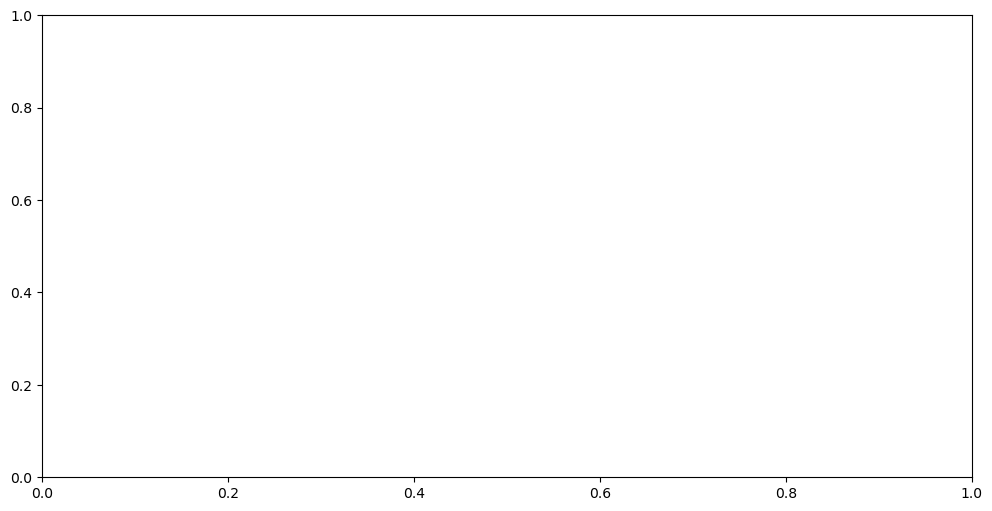

In [38]:
# Plot the average price elasticity for each product category over time (monthly)
plt.figure(figsize=(12, 6))

# Line plot for each product category's average price elasticity over time
sns.lineplot(data=monthly_elasticity, x='month', y='avg_price_elasticity', hue='product_category')

# Adding titles and labels
plt.title('Average Price Elasticity by Product Category (Monthly)')
plt.xlabel('Month')
plt.ylabel('Average Price Elasticity')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()
